In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/annotated_data.csv')
df=df[df['category'].str.len()>1]

In [3]:
import re
from spellchecker import SpellChecker

import nltk
nltk.download('stopwords')
nltk.download('punkt')
french_stopwords = nltk.corpus.stopwords.words('french')
french_stopwords.remove('l') # litre

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
lemmatizer = FrenchLefffLemmatizer()


def clean_text(text):
    """
    Applies some pre-processing on the given text
    """
    
    # convert text to lowercase
    text = text.lower()

    # remove numbers, symbols and ponctuation
    text = re.sub(r"[^A-Za-z]", " ", text)

    # remove leading whitespaces
    text = text.strip()

    # remove stop words
    tokenize_sentence = nltk.tokenize.word_tokenize(text)
    words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]

    # lemitization
    words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)
    text = ' '.join(w for w in words_lemmatize)

    # spell check
    #spell = SpellChecker(language='fr')
    #text = spell.correction(text)

    return text

[nltk_data] Downloading package stopwords to /home/maher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/maher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df['Product_Designation']=[clean_text(str(text)) for text in df['Product_Designation']]
df['supplier_name']=[clean_text(str(text)) for text in df['supplier_name']]
df['full_designation']=[df['Product_Designation'].values[i]+" "+df['supplier_name'].values[i] for i in range(df.shape[0])]

In [5]:
X=df[['supplier_name','Product_Designation']]
y=df['category']

from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y)

label_map = dict(zip(lbl_enc.transform(lbl_enc.classes_),lbl_enc.classes_))

In [6]:
X['full_designation'] = df['full_designation']

<ipython-input-6-f72a2c6fa215>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['full_designation'] = df['full_designation']


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X['full_designation'], y, test_size=0.2, stratify=df['category'], random_state=13)

## Vectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1))

corpus = X_train
ctv.fit(corpus)

xtrain_ctv =  ctv.transform(X_train) 
xvalid_ctv = ctv.transform(X_valid)

## Classifier training

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
from keras.utils.np_utils import to_categorical

y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_valid)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [12]:
model = Sequential([
    Dense(512, input_shape=(0,2950)),
    Activation('relu'),
    
    Dropout(0.4),
    
    Dense(units=15),
    Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    xtrain_ctv, y_train_enc,
    batch_size=32,
    epochs=500,
    verbose=1,
    validation_data=(xvalid_ctv,y_val_enc),
    callbacks=[early_stop]
)

Epoch 1/500


/home/maher/.local/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


57/57 [==============================] - 12s 26ms/step - loss: 2.4248 - accuracy: 0.3218 - val_loss: 1.5073 - val_accuracy: 0.4637
Epoch 2/500
57/57 [==============================] - 1s 19ms/step - loss: 1.1944 - accuracy: 0.5919 - val_loss: 0.7926 - val_accuracy: 0.8198
Epoch 3/500
57/57 [==============================] - 1s 19ms/step - loss: 0.5094 - accuracy: 0.9143 - val_loss: 0.4436 - val_accuracy: 0.8989
Epoch 4/500
57/57 [==============================] - 1s 19ms/step - loss: 0.2125 - accuracy: 0.9740 - val_loss: 0.3235 - val_accuracy: 0.9297
Epoch 5/500
57/57 [==============================] - 1s 19ms/step - loss: 0.0890 - accuracy: 0.9933 - val_loss: 0.2868 - val_accuracy: 0.9297
Epoch 6/500
57/57 [==============================] - 1s 19ms/step - loss: 0.0569 - accuracy: 0.9918 - val_loss: 0.2666 - val_accuracy: 0.9341
Epoch 7/500
57/57 [==============================] - 1s 20ms/step - loss: 0.0336 - accuracy: 0.9988 - val_loss: 0.2599 - val_accuracy: 0.9341
Epoch 8/500
57/57

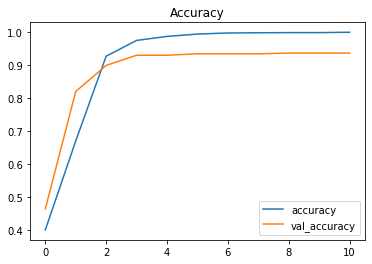

In [14]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['accuracy','val_accuracy']].plot(figsize=[6,4])
plt.title("Accuracy")
plt.show()

In [15]:
y_pred = np.argmax(model.predict(xvalid_ctv), axis=-1)
y_pred

array([10,  7,  5,  2, 10,  1,  1,  8,  7, 11,  7,  7,  7,  7,  7,  6,  7,
        5, 14,  7,  7,  7,  5,  6,  1, 10,  8,  7, 14,  8,  7,  3, 14,  7,
       14, 12,  6, 14,  8,  7,  7,  3, 10, 14,  0,  3, 14,  6,  8,  7,  7,
        6,  7,  8,  6,  1,  7,  7,  7,  7, 10,  7,  7,  1,  5,  9, 10,  7,
       14,  8,  7, 10,  7,  7,  7, 14,  7,  1,  2,  7,  7, 14,  7,  7,  8,
        7,  8,  1,  7,  0,  5,  7, 12,  6,  6, 10,  6,  7, 14,  7,  2,  7,
       11,  5,  4,  1,  7, 10,  7,  7,  7,  7, 10,  6, 14, 10,  5,  2,  7,
        1, 10,  4,  9,  4, 14,  7,  4,  3,  1,  6, 10,  7,  1,  4, 10,  5,
        1,  7,  5,  7,  7,  7,  7,  7,  7,  6,  7,  7,  7,  1,  1,  7,  2,
       12,  7,  7,  7,  1,  7,  7,  7, 11,  8,  5,  2,  1,  5,  7,  7,  2,
        1,  1,  7,  7,  4, 14,  1,  7,  1,  7,  7,  9,  7,  2,  6, 11,  7,
        7,  7,  7, 14, 11,  9,  7,  7,  9,  7,  7, 10,  7,  3,  7,  5,  7,
        7,  1,  0,  7,  7,  7,  7, 14,  7,  4,  3,  7,  7,  1,  7,  7,  8,
        7,  2,  7,  7, 12

In [16]:
[label_map[p] for p in y_pred][:3]

['Personal', 'Groceries', 'Flatware']

## New Item Prediction

In [17]:
item=corpus[51]
item="telephone huawei y7 2019"
item = clean_text(item)

vect=ctv.transform([item])
label_map[np.argmax(model.predict(vect))]

'Utilities'

In [18]:
# dumping models
import pickle
pickle.dump(ctv, open('./dumps/vectorizer.pkl', "wb"))
pickle.dump(label_map, open('./dumps/label_map.pkl', "wb"))
model.save('./dumps/')

INFO:tensorflow:Assets written to: ./dumps/assets


## prediction with loaded models


In [19]:
import pickle
from tensorflow.keras.models import load_model
from numpy import argmax

vectorizer2 = pickle.load(open('./dumps/vectorizer.pkl', 'rb'))
label_map2=pickle.load(open('./dumps/label_map.pkl', 'rb'))
model2 = load_model('./dumps/')

In [20]:
item="telephone huawei y7 2019"
# item = clean_text(item)

vect=vectorizer2.transform([item])
label_map2[argmax(model2.predict(vect))]

'Utilities'

In [21]:
test=['item1','item2']

In [23]:
vect=vectorizer2.transform(test)
vect

<2x2950 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [35]:
y_pred = [label_map2[argmax(model2.predict(vector))]for vector in vect]
y_pred

['Groceries', 'Groceries']